# Unsupervised Learning: Clustering Techniques

## What is Unsupervised Learning?

Unsupervised learning is a type of machine learning where **no labeled data** is provided. Instead, the model tries to **identify patterns, groupings, or structures** in the data based on similarities or statistical properties.

Unlike supervised learning (where we have inputs and known outputs), in unsupervised learning, we only have input features — and the model attempts to derive insights such as **clusters**, **associations**, or **dimensionality reduction**.

---

## What We'll Cover

In this notebook, we will explore two key clustering algorithms:

1. **K-Means Clustering** – a partitioning method
2. **Agglomerative Clustering** - a hierachical clustering method
3. **DBSCAN** – a density-based method

We’ll use two example datasets:
- A customer segmentation dataset from a mall
- A synthetic dataset with non-linear cluster shapes

---

## Part 1: K-Means Clustering (Mall Customer Segmentation Data)

### Dataset: Mall Customer Segmentation  
Source: [Mall Customers Dataset on Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

### About the Dataset
This dataset originates from a supermarket mall that uses membership cards to collect and manage customer information. Each entry in the dataset represents a unique customer and includes key demographic and behavioral attributes that can be used for customer segmentation, targeted marketing, or personalized service offerings.

### Problem Statement
You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

---

### Objective:

We aim to segment customers based on:
- **Annual Income (k$)**
- **Spending Score (1–100)**

This helps understand customer behavior and group them into meaningful clusters for targeted marketing.

---

#### Import Necessary Libraries

In [1]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import os # for file path operations
from sklearn.cluster import KMeans, AgglomerativeClustering # clustering algorithms
from sklearn.preprocessing import StandardScaler # feature scaling
from sklearn.metrics import silhouette_score # silhouette score for evaluating clustering
from scipy.cluster.hierarchy import dendrogram, linkage # hierarchical clustering
import warnings # to suppress warnings
warnings.filterwarnings("ignore")

#### Load Dataset

In [2]:
# load the dataset
data = pd.read_csv('Mall_Customers.csv')

In [3]:
df = data.copy()
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### Rename Columns

In [4]:
# rename columns for better readability
df.rename(columns={
    'CustomerID': 'customer_id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income_k',
    'Spending Score (1-100)': 'spending_score'
}, inplace=True)
df.head()

,customer_id,gender,age,annual_income_k,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### Exploratory Data Analysis (EDA)

In [5]:
# data size
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")

Dataset size: 200 rows and 5 columns


In [6]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      200 non-null    int64 
 1   gender           200 non-null    object
 2   age              200 non-null    int64 
 3   annual_income_k  200 non-null    int64 
 4   spending_score   200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# view gender unique values
df['gender'].value_counts()

gender
Female    112
Male       88
Name: count, dtype: int64

In [8]:
# missing Values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
missing_values

Missing values in each column:


customer_id        0
gender             0
age                0
annual_income_k    0
spending_score     0
dtype: int64

In [9]:
# summary statistics
print("Summary statistics:")
df.describe()

Summary statistics:


,customer_id,age,annual_income_k,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


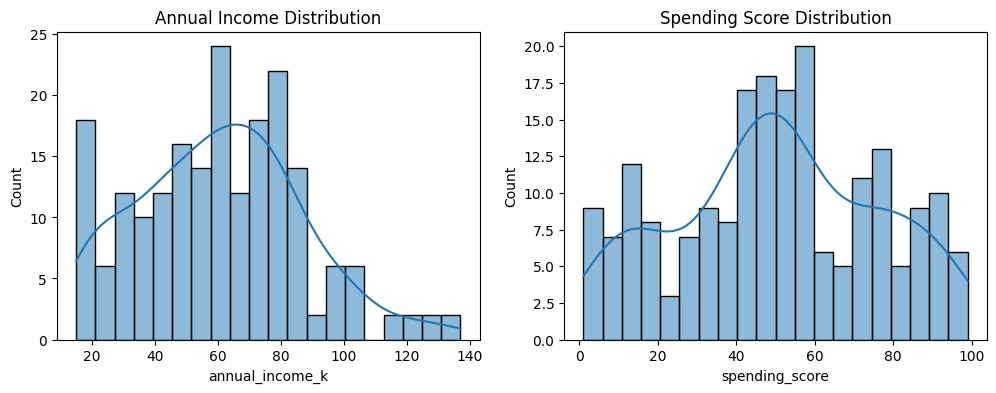

In [10]:
# plotting the distribution of 'Annual Income' and 'Spending Score'
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['annual_income_k'], kde=True, bins=20)
plt.title("Annual Income Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['spending_score'], kde=True, bins=20)
plt.title("Spending Score Distribution")
plt.show()

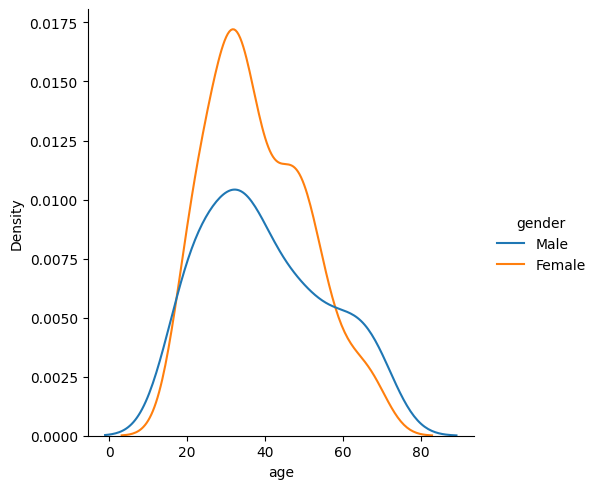

In [11]:
# visual gender density
sns.displot(df, x = 'age',hue='gender', kind='kde')
plt.show()

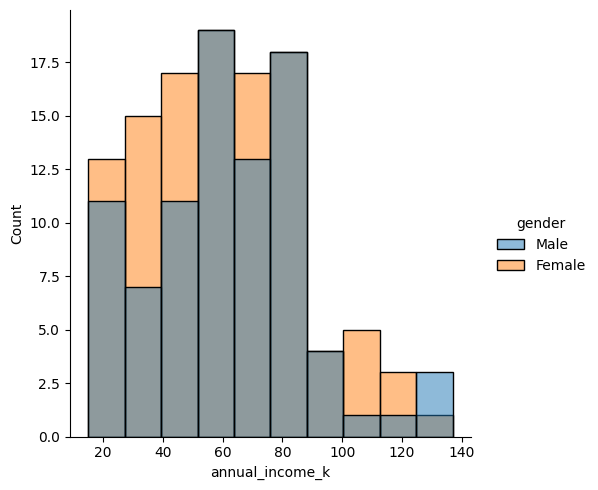

In [12]:
# distribution of annual income by gender
sns.displot(df, x = 'annual_income_k',hue='gender', kind='hist')
plt.show()

#### Feature Selection & Scaling
K-Means and Hierarchical Clustering are distance-based algorithms; scaling ensures equal feature influence. If you don’t scale the features, the algorithm will give much more importance to `Annual Income` simply because its numbers are larger. This causes `bias in clustering`, because the algorithm will mostly group based on income and largely ignore age.

In [13]:
# select features for clustering
X = df[['annual_income_k', 'spending_score']]

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nScaled Data Sample:")
X_scaled[:5]


Scaled Data Sample:


array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

#### K-Means Clustering (Partion Based Clustering)

The Elbow Method is a technique used in K-Means Clustering to determine the optimal number of clusters (K) by evaluating how the Within-Cluster Sum of Squares (WCSS) changes as K increases. The elbow point indicates the optimal number of clusters. Before the elbow, adding more clusters significantly improves clustering (reduces WCSS). After the elbow, adding more clusters yields diminishing returns.

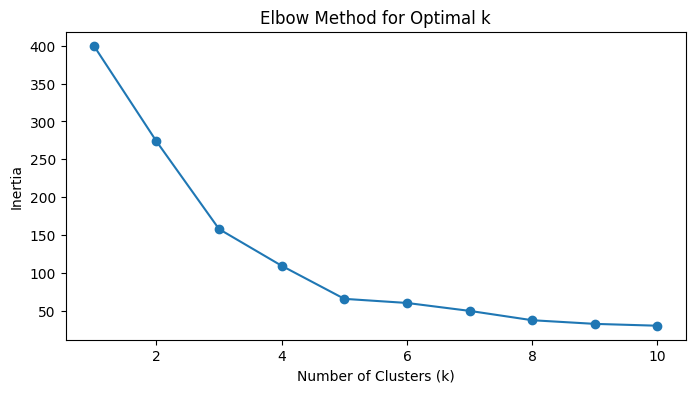

In [14]:
# elbow method to find optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

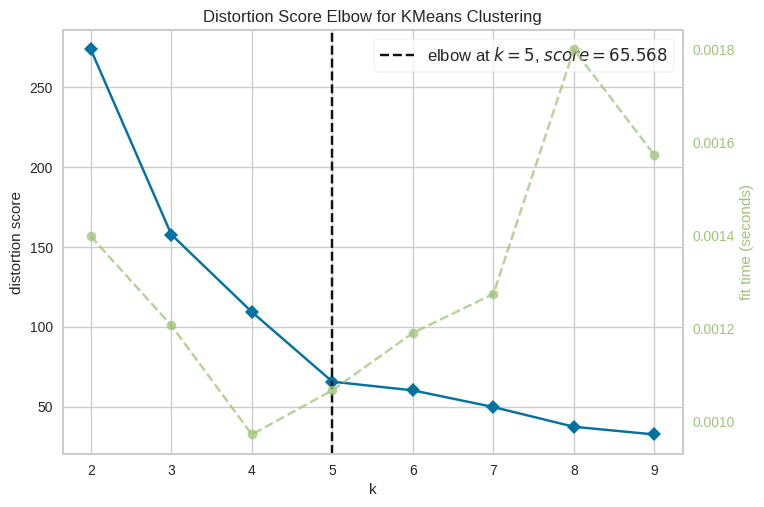

In [15]:

# getting optimal number of clusters using yellowbrick
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(X_scaled)
visualizer.show()
plt.show()

**Interpretation**

The graphs above show the reduction of a distortion score as the number of clusters increases. However, there is no clear "elbow" visible. The underlying algorithm suggests 5 clusters. A choice of 5 or 6 clusters seems to be fair.

**Train K-Means with k=5**

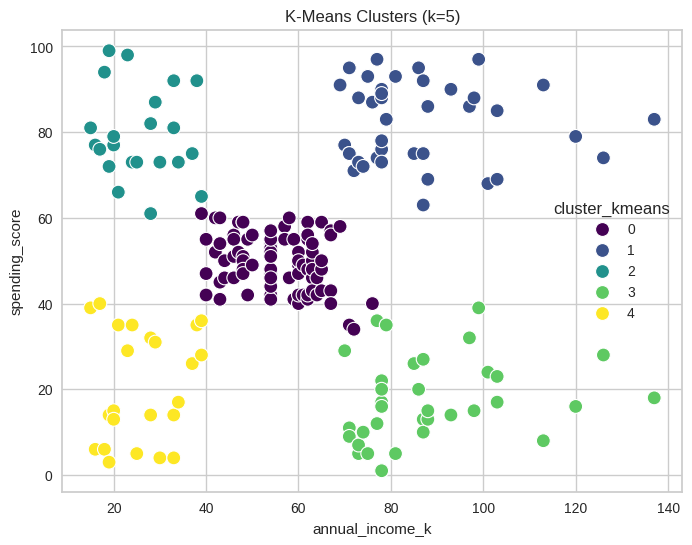

In [16]:
# training KMeans with optimal k=5 from the elbow method
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='annual_income_k', y='spending_score', hue='cluster_kmeans', palette='viridis', s=100)
plt.title("K-Means Clusters (k=5)")
plt.show()

**Cluster Descriptions**
- **Cluster 0:** Low income, low spending (Budget-conscious).
- **Cluster 1:** High income, low spending (Savvy spenders).
- **Cluster 2:** Medium income, medium spending (Average).
- **Cluster 3:** High income, high spending (Target customers).
- **Cluster 4:** Low income, high spending (Carefree spenders).

#### Agglomerative Clustering (Hierarchical Clustering)
Here, we will use `Dendrogram` to Find Optimal Clusters

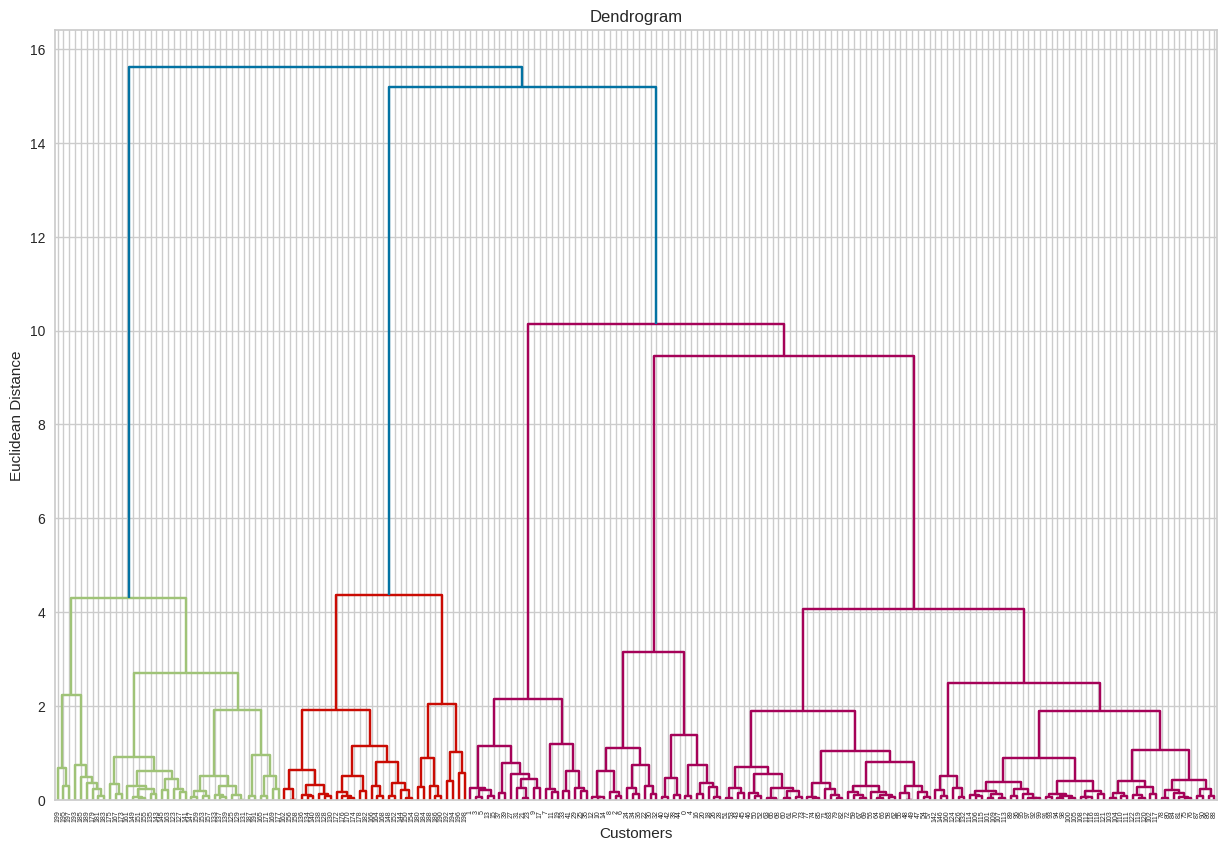

In [17]:
# plot dendrogram
plt.figure(figsize=(15, 10))
dend = dendrogram(linkage(X_scaled, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()

**Interpretation**

Vertical line with the longest distance without horizontal lines suggests k=5.

**Agglomerative Clustering (Hierarchical Clustering)**

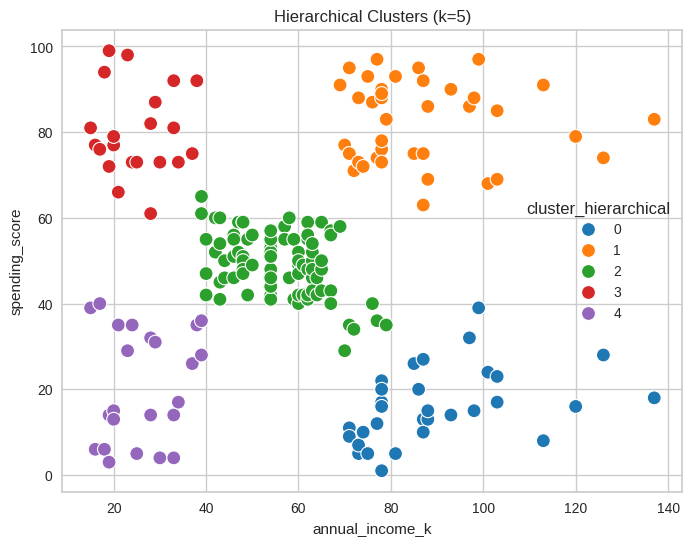

In [18]:
# train agglomerative clustering
hc = AgglomerativeClustering(n_clusters=5, linkage='ward')
df['cluster_hierarchical'] = hc.fit_predict(X_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='annual_income_k', y='spending_score', hue='cluster_hierarchical', palette='tab10', s=100)
plt.title("Hierarchical Clusters (k=5)")
plt.show()

#### Algorithm Comparison
Here, we will use silhouette_score to compare the measure of how well each data points fits into its assigned cluster compared to other clusters. In short, it evaluates the quality of clustering and chooses optimal number of clusters (k)

In [19]:
# silhouette scores
kmeans_score = silhouette_score(X_scaled, df['cluster_kmeans'])
hc_score = silhouette_score(X_scaled, df['cluster_hierarchical'])

comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [kmeans_score, hc_score]
})

print("\nAlgorithm Performance:")
display(comparison)


Algorithm Performance:


,Algorithm,Silhouette Score
0,K-Means,0.554657
1,Hierarchical,0.553809


**Conclusion**
- Both methods perform similarly (k=5 is optimal).
- K-Means slightly edges out in compactness.

#### Recommendations
- Personalized Marketing: Tailor campaigns based on cluster traits.
- Dynamic Pricing: Adjust for high-spending clusters.

---

## Part 2: DBSCAN – Density-Based Clustering
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise and is one of clustering algorithms implemented in scikit-learn library.

As the name of paper suggests the core idea of DBSCAN is around concept of dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”. To do these two parameters are required for DBSCAN algorithm.

Unlike K-Means, DBSCAN groups points based on **density connectivity**, making it more effective for discovering **arbitrary-shaped clusters** and handling **outliers** robustly.

---

In [20]:
# import DBSCAN for density-based clustering
from sklearn.cluster import DBSCAN

**Run DBSCAN and Count Clusters**

In [21]:
eps_values = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7]  # maximum distance between two points to be considered neighbors.
min_samples = [3,4,5,6,7,8,9,10] # minimum number of points required to form a dense region (core point).

# run DBSCAN and Count Clusters
num_clustering = []
for i in range(len(eps_values)):
    for j in range(len(min_samples)):
        DBSCan_clust = DBSCAN(eps=eps_values[i], min_samples=min_samples[j]).fit(X_scaled)
        num_clustering.append(len(np.unique(DBSCan_clust.labels_)))

**Visualize the impact of different eps and min_samples**

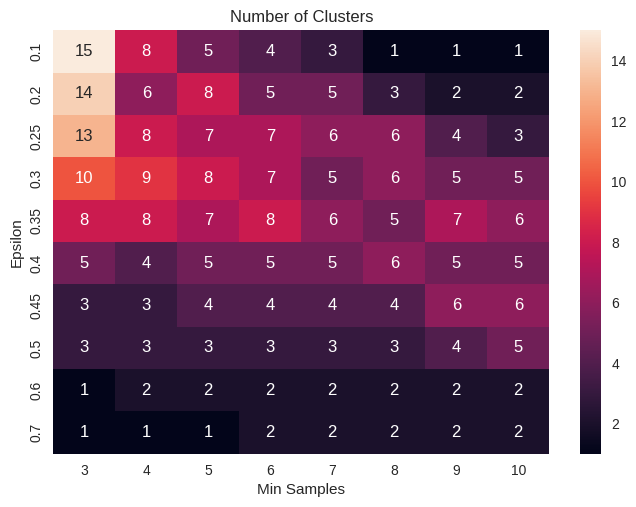

In [22]:
num_clustering_matrix = np.array(num_clustering).reshape(len(eps_values), len(min_samples))

# create a heatmap
sns.heatmap(num_clustering_matrix, annot=True, fmt="d", xticklabels=min_samples, yticklabels=eps_values)
plt.xlabel('Min Samples')
plt.ylabel('Epsilon')
plt.title('Number of Clusters')
plt.show()

**Select specific DBSCAN parameters and analyze the clustering result**

In [23]:
# select Epsilon = 0.35 and min samples = 4
DBSCan_clust = DBSCAN(eps=0.35, min_samples=4).fit(X_scaled)
labels = DBSCan_clust.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

**Visualize the clusters formed by DBSCAN**

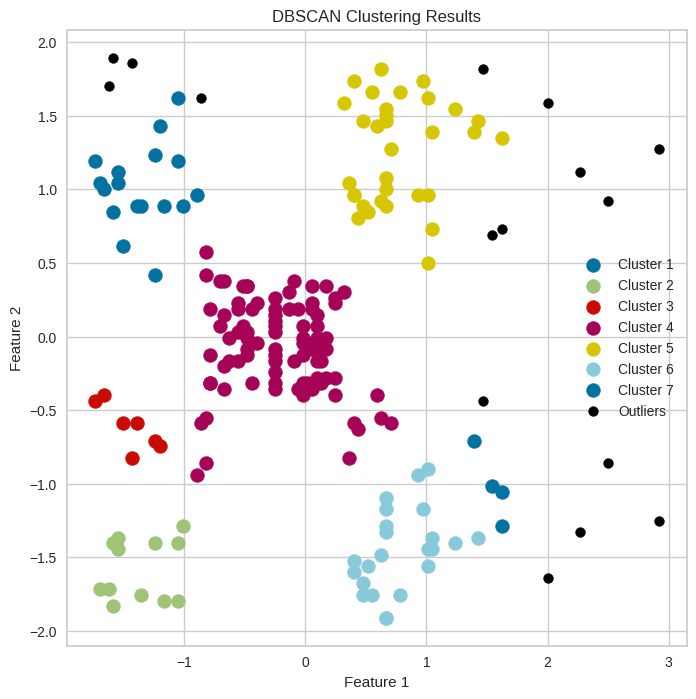

In [24]:
plt.figure(figsize=(8, 8))

# Plot each cluster with default color cycling
for i in range(n_clusters_):
    plt.scatter(
        X_scaled[labels == i, 0], 
        X_scaled[labels == i, 1], 
        s=100, 
        label=f'Cluster {i + 1}'
    )

# Plot outliers (label -1) in black
plt.scatter(
    X_scaled[labels == -1, 0], 
    X_scaled[labels == -1, 1], 
    s=50, 
    c='black', 
    label='Outliers'
)

plt.legend()
plt.title("DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [25]:
# Exclude noise points (label == -1)
core_samples_mask = labels != -1
if len(set(labels[core_samples_mask])) > 1:
    dbscan_silhouette = silhouette_score(X_scaled[core_samples_mask], labels[core_samples_mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.3f}")
else:
    print("Silhouette score cannot be computed: less than 2 clusters found (excluding noise).")

DBSCAN Silhouette Score (excluding noise): 0.511
